### Proyecto metaheurísticas
## Metaheurísticas aplicadas a procesos de Ing. y GC organizacional

### Versión 2 con factores en evaluación similitudes

### Alumno: Héctor Rojas Pescio 

###### Librerías Auxiliares

In [34]:
#Utilitarios
import pandas as pd
import numpy as np
import math
import random
from random import randrange

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid') # Gráficos estilo seaborn
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 100

#Sistema
import sys
import time
import glob
import gc

#Alertas
import warnings
warnings.filterwarnings("ignore")

##### Librerías Ontologías

In [35]:
#Ontologías OWL
from owlready2 import *

import ontospy

#Ontologías Grafos
from rdflib.graph import Graph

##### Librerías PLN

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.metrics import distance

### Alineación de Ontologías
#### Globales

In [37]:
#Ontology similarity factor
#------------------------------
onto_sim_fact = .0

#Smallest entities array
gl_sm_lst_cl = []
gl_sm_lst_in = []
gl_sm_lst_dp = []
gl_sm_lst_op = []

#Largest entities array
gl_lg_lst_cl = []
gl_lg_lst_in = []
gl_lg_lst_dp = []
gl_lg_lst_op = []

#Smallest ontology entities
gl_sm_onto_en = []
gl_lg_onto_en = []

#Solution representation dimensions (number of entities by type)
gl_sol_repr_dim = []

#### Similitud Ontología

In [38]:
def get_ontology_similarity(onto_sm, onto_lg, dbg=False):
    sim_score = .0
    cl_score = 1.0
    in_score = 1.0
    dp_score = 1.0
    op_score = 1.0
    
    if type(onto_sm) == owlready2.namespace.Ontology and type(onto_lg) == owlready2.namespace.Ontology:
    
        #Namespace
        onto_sm_ns = str(onto_sm.get_namespace)
        onto_lg_ns = str(onto_lg.get_namespace)
        ns_score = distance.jaro_winkler_similarity(onto_sm_ns, onto_lg_ns)        

        #Structure
        onto_sm_lst_cl = len(list(onto_sm.classes()))
        onto_sm_lst_in = len(list(onto_sm.individuals()))
        onto_sm_lst_dp = len(list(onto_sm.data_properties()))
        onto_sm_lst_op = len(list(onto_sm.object_properties()))

        onto_lg_lst_cl = len(list(onto_lg.classes()))
        onto_lg_lst_in = len(list(onto_lg.individuals()))
        onto_lg_lst_dp = len(list(onto_lg.data_properties()))
        onto_lg_lst_op = len(list(onto_lg.object_properties()))

        #Clases
        min_cl = min([onto_sm_lst_cl, onto_lg_lst_cl])
        max_cl = max([onto_sm_lst_cl, onto_lg_lst_cl])
        if(max_cl > 0):
            cl_score = min_cl / max_cl    

        #Individuals
        min_in = min([onto_sm_lst_in, onto_lg_lst_in])
        max_in = max([onto_sm_lst_in, onto_lg_lst_in])
        if(max_in > 0):
            in_score = min_in / max_in

        #DataProperties
        min_dp = min([onto_sm_lst_dp, onto_lg_lst_dp])
        max_dp = max([onto_sm_lst_dp, onto_lg_lst_dp])
        if(max_dp > 0):
            dp_score = min_dp / max_dp

        #ObjectProperties
        min_op = min([onto_sm_lst_op, onto_lg_lst_op])
        max_op = max([onto_sm_lst_op, onto_lg_lst_op])    
        if(max_op > 0):
            op_score = min_op / max_op    

        sim_score = (.27*ns_score + .23*cl_score + .2*in_score + .15*dp_score + .15*op_score)

    if dbg == True:
        print("----------------------------------------------------------")
        print("ONTOLOGY SIMILARITY\n{}\n{}".format(onto_sm_ns, onto_lg_ns))
        print("----------------------------------------------------------")
        print('ns_score: {}'.format(round(ns_score,2)))
        print('cl_score: {}'.format(round(cl_score,2)))
        print('in_score: {}'.format(round(in_score,2)))
        print('dp_score: {}'.format(round(dp_score,2)))
        print('op_score: {}'.format(round(op_score,2)))
        print("----------------------------------------------------------")
    
    return round(sim_score,5)

#### Similitud Clases

In [39]:
def class_similarity(cl_1, cl_2, dbg=False):
    cl_score = .0
    id_score = .0
    cb_score = .0
    mr_score = .0
    pr_score = .0
        
    if type(cl_1) == owlready2.entity.ThingClass and type(cl_2) == owlready2.entity.ThingClass :
        
        #Id
        id_score = round(distance.jaro_winkler_similarity(cl_1.name, cl_2.name),5)
            
        #SubclassOf
        cb_score = .0
        lst_sbc_scr = []
        for sbcl1 in cl_1.is_a:
             for sbcl2 in cl_2.is_a:               
                lst_sbc_scr.append(distance.jaro_winkler_similarity(str(sbcl1), str(sbcl2)))                     
        try:
            cb_score = round(max(lst_sbc_scr), 5)
        except:
            print("An exception occurred")
        
        #Method Resolution Order
        mr_score = round(distance.jaro_winkler_similarity(owl_tag2str(cl_1.mro), owl_tag2str(cl_2.mro)),5)
        
        #Properties similarity (annotations, comments)        
        lst_prop_cl1 = []
        lst_prop_cl2 = []
        
        for prop in cl_1.get_properties(cl_1):
            for value in prop[cl_1]:                
                lst_prop_cl1.append([prop.python_name, value])
                
        for prop in cl_2.get_properties(cl_2):
            for value in prop[cl_2]:
                lst_prop_cl2.append([prop.python_name, value])

        prop_size = max([len(lst_prop_cl1), len([lst_prop_cl2])])
        if prop_size > 0:
            for prop_cl1 in lst_prop_cl1:
                lst_prop_scr = []
                for prop_cl2 in lst_prop_cl2:
                    if prop_cl1[0] == prop_cl2[0]: #Same labels
                        lst_prop_scr.append(distance.jaro_similarity(prop_cl1[1], prop_cl2[1]))
                if len(lst_prop_scr) > 0:
                    pr_score = pr_score + max(lst_prop_scr)             
            pr_score = round(pr_score/prop_size,5)
                
        #EquivalentTo

        #Instances

        #TargetForKey

        #DisjointWith

        #DisjointUnionOf
        
    if dbg == True:
        print("----------------------------------------------------------")
        print("CLASS SIMILARITY ({}, {})".format(cl_1.name, cl_2.name))
        print("----------------------------------------------------------")
        print("id_score:{}".format(id_score))
        print("cb_score:{}".format(cb_score))
        print("mr_score:{}".format(mr_score))
        print("pr_score:{}".format(pr_score))
        print("----------------------------------------------------------")

    cl_score = (id_score*.5 + cb_score*.2 + mr_score*.15 + pr_score*.15)
    
    return round(cl_score,5)

#### Similitud Entidades

In [40]:
def individual_similarity(en_1, en_2, dbg=False):
    en_score = .0
    id_score = .0
    cb_score = .0
    ir_score = .0
    pr_score = 1.0

    #Id
    id_score = round(distance.jaro_winkler_similarity(en_1.name, en_2.name),5)

    #SubclassOf/Types
    cb_score = .0        
    lst_sbc_scr = []
    for sbcl1 in en_1.is_a:
         for sbcl2 in en_2.is_a:               
            lst_sbc_scr.append(distance.jaro_winkler_similarity(str(sbcl1), str(sbcl2)))                     
    cb_score = round(max(lst_sbc_scr), 5)

    #Iri
    ir_score = round(distance.jaro_winkler_similarity(owl_tag2str(en_1.get_iri), owl_tag2str(en_2.get_iri)),5)

    #Properties similarity (annotations, comments)        
    lst_prop_en1 = []
    lst_prop_en2 = []

    for prop in en_1.get_properties():
        for value in prop[en_1]:                
            lst_prop_en1.append([prop.python_name, value])

    for prop in en_2.get_properties():
        for value in prop[en_2]:
            lst_prop_en2.append([prop.python_name, value])               
    
    prop_size = max([len(lst_prop_en1), len(lst_prop_en2)])                             
    if prop_size > 0:
        pr_score = .0
        for prop_en1 in lst_prop_en1:
            lst_prop_scr = []
            for prop_en2 in lst_prop_en2:
                if prop_en1[0] == prop_en2[0]: #Same labels
                    lst_prop_scr.append(distance.jaro_similarity(prop_en1[1], prop_en2[1]))
            if len(lst_prop_scr) > 0:
                pr_score = pr_score + max(lst_prop_scr)             
        pr_score = round(pr_score/prop_size,5)

    #SameIndividualAs

    #DifferentIndividuals
    
    if dbg == True:
        print("----------------------------------------------------------")
        print("INDIVIDUAL SIMILARITY ({}, {})".format(en_1.name, en_2.name))
        print("----------------------------------------------------------")
        print("id_score:{}".format(id_score))
        print("cb_score:{}".format(cb_score))
        print("ir_score:{}".format(ir_score))
        print("pr_score:{}".format(pr_score))
        print("----------------------------------------------------------")

    en_score = (id_score*.5 + cb_score*.2 + ir_score*.15 + pr_score*.15)
    
    return round(en_score, 5)

#### Similitud propiedades de datos

In [41]:
def data_property_similarity(dp_1, dp_2, dbg=False):
    dp_score = .0
    id_score = .0
    cb_score = .0
    ir_score = .0
    re_score = 1.0
    fu_score = 0
    
    if str(dp_1.is_a[0]) == 'owl.DatatypeProperty' and str(dp_2.is_a[0]) == 'owl.DatatypeProperty':

        #Id
        id_score = round(distance.jaro_winkler_similarity(dp_1.name, dp_2.name),5)

        #SubclassOf/Types
        cb_score = .0        
        lst_sbc_scr = []
        for sbcl1 in dp_1.is_a:
             for sbcl2 in dp_2.is_a:               
                lst_sbc_scr.append(distance.jaro_winkler_similarity(str(sbcl1), str(sbcl2)))                     
        cb_score = round(max(lst_sbc_scr), 5)

        #Iri
        ir_score = round(distance.jaro_winkler_similarity(owl_tag2str(dp_1.get_iri), owl_tag2str(dp_2.get_iri)),5)

        #Relations    
        lst_rel_dp1 = []
        lst_rel_dp2 = []
        
        for rel in dp_1.get_relations():           
            lst_rel_dp1.append([rel[0], rel[1]])

        for rel in dp_2.get_relations():           
            lst_rel_dp2.append([rel[0], rel[1]])        

        rel_size = max([len(lst_rel_dp1), len(lst_rel_dp2)])        
        if rel_size > 0:
            re_score = .0
            for rel_dp1 in lst_rel_dp1:
                lst_rel_scr = []
                for rel_dp2 in lst_rel_dp2:
                    if rel_dp1[0] == rel_dp2[0]: #Relation
                        #print("{} == {}".format(rel_dp1[1], rel_dp1[1]))
                        lst_rel_scr.append(distance.jaro_similarity(rel_dp1[1], rel_dp2[1]))
                if len(lst_rel_scr) > 0:
                    re_score = re_score + max(lst_rel_scr)            
            re_score = round(re_score/rel_size,5)                
        
        #IdFunctionalFor
        fu_score = round(distance.jaro_winkler_similarity(
            owl_tag2str(dp_1.is_functional_for),owl_tag2str(dp_2.is_functional_for)),5)
        
    if dbg == True:
        print("----------------------------------------------------------")
        print("DATA PROPERTY SIMILARITY ({}, {})".format(dp_1.name, dp_2.name))
        print("----------------------------------------------------------")
        print("id_score:{}".format(id_score))
        print("cb_score:{}".format(cb_score))
        print("ir_score:{}".format(ir_score))
        print("re_score:{}".format(re_score))
        print("fu_score:{}".format(fu_score))
        print("----------------------------------------------------------")

    dp_score = (id_score*.27 + cb_score*.23 + ir_score*.2 + re_score*.15 + fu_score*.15)
    
    return round(dp_score,5)

#### Similitud propiedades de objetos

In [42]:
def object_property_similarity(op_1, op_2, dbg=False):
    op_score = .0
    id_score = .0
    cb_score = .0
    mr_score = .0
    re_score = 1.0
    fu_score = 0
    
    if str(op_1.is_a[0]) == 'owl.ObjectProperty' and str(op_2.is_a[0]) == 'owl.ObjectProperty':

        #Id
        id_score = round(distance.jaro_winkler_similarity(op_1.name, op_2.name),5)

        #SubclassOf/Types
        cb_score = .0        
        lst_sbc_scr = []
        for sbcl1 in op_1.is_a:
             for sbcl2 in op_2.is_a:               
                lst_sbc_scr.append(distance.jaro_winkler_similarity(str(sbcl1), str(sbcl2)))                     
        cb_score = round(max(lst_sbc_scr), 5)

        #Method Resolution Order
        mr_score = round(distance.jaro_winkler_similarity(owl_tag2str(op_1.mro), owl_tag2str(op_2.mro)),5)
        
        #Relations    
        lst_rel_op1 = []
        lst_rel_op2 = []
        
        for rel in op_1.get_relations():           
            lst_rel_op1.append([rel[0], rel[1]])

        for rel in op_2.get_relations():           
            lst_rel_op2.append([rel[0], rel[1]])        

        rel_size = max([len(lst_rel_op1), len(lst_rel_op2)])        
        if rel_size > 0:
            re_score = .0
            for rel_op1 in lst_rel_op1:
                lst_rel_scr = []
                for rel_op2 in lst_rel_op2:
                    if rel_op1[0] == rel_op2[0]: #Relation                        
                        lst_rel_scr.append(distance.jaro_similarity(rel_op1[1], rel_op2[1]))
                if len(lst_rel_scr) > 0:
                    re_score = re_score + max(lst_rel_scr)            
            re_score = round(re_score/rel_size,5)                
        
         #IdFunctionalFor
        fu_score = round(distance.jaro_winkler_similarity(
            owl_tag2str(op_1.is_functional_for),owl_tag2str(op_2.is_functional_for)),5)
        
        if dbg == True:
            print("----------------------------------------------------------")
            print("OBJECT PROPERTY SIMILARITY ({}, {})".format(op_1.name, op_2.name))
            print("----------------------------------------------------------")
            print("id_score:{}".format(id_score))
            print("cb_score:{}".format(cb_score))
            print("mr_score:{}".format(mr_score))
            print("re_score:{}".format(re_score))
            print("fu_score:{}".format(fu_score))
            print("----------------------------------------------------------")

        op_score = (id_score*.27 + cb_score*.23 + mr_score*.2 + re_score*15 + fu_score*.15)
    
    return round(op_score,5)

##### Matriz de correspondencia

In [43]:
def create_correspondece_matrix(onto_sm):
    onto_sm_voc_size = get_onto_voc_size(onto_sm)
    corresp_matrix = [[-1, np.NaN]] * onto_sm_voc_size
    return corresp_matrix

def create_entity_corresp_matrix(entity_size):   
    entity_corresp_matrix = [[-1, np.NaN]] * entity_size
    return entity_corresp_matrix

##### Evaluación de Correspondencia Contextual

In [44]:
#Función vecino explícito OK
#All types

#Función de extracción de superentidad OK
#All types

#Función de extracción de subentidades OK
#All types

#Función Similitud de jerarquía OK
#All types with 

#Similitud de propagación de jerarquía

#Dominio de propiedad/similitud de rango

#Clase como similitud de dominio/rango

#Correspondencia entrecruzada (Criss-cross correspondence)

#Evaluación basada en explicaciones

##### Evaluación del Nivel de Alineación

In [45]:
#Tamaño de alineación
def alignment_size(corresp_matrix):
    return len(corresp_matrix)

#Consistencia de alineación

#Coherencia de alineación

#Preservación estructural

#Alineación entrecruzada (Criss-cross alignment)

#### Agregación de similitudes (Función objetivo)

Auxiliares

In [46]:
def get_alignment_score(corresp_matrix):    
    #total = [sum(al[1]) for al in corresp_matrix ]
    total = 0
    for al in corresp_matrix:
        if math.isnan(al[1]) == False:
            total = total + al[1]
    return round(total, 3)

def create_align_score_lst(corresp_mtx_lst):
    align_score_lst = []
    for cm in range(len(corresp_mtx_lst)):
        align_score_lst.append([cm, get_alignment_score(corresp_mtx_lst[cm])])
    return align_score_lst

Agregación máxima

In [47]:
def get_max_aggregation(align_score_lst, num_best=1):
    bst_scr_lst = sorted(align_score_lst,key=lambda l:l[1], reverse=True)
    return bst_scr_lst[0:num_best]

Agregación promedio ponderada

Agregación promedio ponderada ordenada

#### Auxiliares ontologías

In [48]:
def get_onto_voc_size(onto):
    #Number of entities in OWL ontology
    voc_size = len(list(onto.classes())) + len(list(onto.object_properties())) + len(list(onto.data_properties())) + len(list(onto.individuals()))        
    return voc_size

def load_owl_ontology(onto_path):
    owl_onto = get_ontology(onto_path)
    owl_onto.load() 
    return owl_onto

def load_rdf_ontology(onto_path):
    rdf_onto = ontospy.Ontospy(onto_path, verbose=True)
    return rdf_onto

def owl_tag2str(tag_obj):
    str_tag = str(tag_obj)
    pos = str_tag.find(' of ')
    if pos > -1:
        str_tag = str_tag[pos+4:len(str_tag)-1]
    else :
        str_tag = ''
    return str_tag

def get_correct_map(onto_align, onto_refer):
    #Not defined
    raise Exception('Undefined')
    
def get_found_map(onto_align_res):
    #Not defined
    raise Exception('Undefined')
    
def get_exist_map(onto_align, onto_refer):
    #Not defined
    raise Exception('Undefined')
    
def get_entities_by_type(onto, entity_type):
    en_lst = []
    if type(onto) == owlready2.namespace.Ontology:
        if entity_type == 'cl':
            en_lst = list(onto.classes())
        elif entity_type == 'in':
            en_lst = list(onto.individuals())
        elif entity_type == 'dp':
            en_lst = list(onto.data_properties())
        elif entity_type == 'op':
            en_lst = list(onto.object_properties())
    return en_lst

def entity_similarity(entity_1, entity_2, ent_type):
    score = 0.0
    if ent_type == 0:
        score = class_similarity(entity_1, entity_2)
    elif ent_type == 1:       
        score = individual_similarity(entity_1, entity_2) 
    elif ent_type == 2:
        score = data_property_similarity(entity_1, entity_2)
    elif ent_type == 3:
        score = object_property_similarity(entity_1, entity_2) 
    return score

def save_results_cs(onto_align_res):
    for i in range(len(onto_align_res)):
        pd.DataFrame(onto_align_res[i]).to_csv(r'csv/gen_ga{}.txt'.format(i), index = False)
        
def get_onto_tree(onto_1_path, onto_2_path):
    #Load RDF ontologies
    try :
        rdf_onto_1 = load_rdf_ontology(onto_1_path)
        rdf_onto_2 = load_rdf_ontology(onto_2_path)

        print("----------------------------------------------------------")
        print("ONTOLOGY 1 ({})".format(owl_onto_1.get_namespace))
        print("----------------------------------------------------------")
        rdf_onto_1.printClassTree()

        print("----------------------------------------------------------")
        print("ONTOLOGY 2 ({})".format(owl_onto_2.get_namespace))
        print("----------------------------------------------------------")
        rdf_onto_2.printClassTree()
    except:
        print("Error al serializar archivos OWL")

def plot_results(lst_scr):
    fig= plt.figure(figsize=(10,3))
    agr_scr = []
    for scr in lst_scr:
        agr_scr.append(scr[0][1])

    plt.plot(agr_scr)
    plt.ylabel('FF')
    plt.xlabel('Iteraciones')
    plt.show() 
    
def plot_perfomance(itr, scr, xtm):
    plt.figure(figsize=(10, 6))

    ax = plt.subplot(221)
    plt.plot(itr, scr, color='#41a5f5', marker='o')
    plt.xlabel('Iteraciones')
    plt.ylabel('Puntaje')   
    plt.title('Puntaje de Agregación', fontsize=9)
    ax.set_ylim([55, 120])
    
    plt.subplot(222)
    plt.plot(itr, xtm, color='#51a71c', marker='o')
    plt.xlabel('Iteraciones')
    plt.ylabel('Segundos')
    plt.title('Tiempo', fontsize=9)
    
    plt.suptitle('Desempeño ILS', fontsize=12)
    plt.show()
    
    print("Agregration scores: {}".format(lst_scr))
    print("Execution time: {} seg".format(lst_xtm, 2))

#### Agregación de similitudes

In [49]:
def align_ontologies(onto_1_path, onto_2_path, meta_name='GA',
                     max_iter=100, pop_size=100, pct_elit=0.2, 
                     pct_slct=0.2, pct_cros=0.8, pct_muta=0.2,
                     dbg=False):        
   
    #Solution representation
    alignment_results = []
    
    #Load OWL ontologies
    owl_onto_1 = load_owl_ontology(onto_1_path)
    owl_onto_2 = load_owl_ontology(onto_2_path)
    
    #if dbg==True:
    #    get_onto_tree(onto_1_path, onto_2_path)
    
    #Get vocabulary size
    num_ent_owl_onto_1 = get_onto_voc_size(owl_onto_1)
    num_ent_owl_onto_2 = get_onto_voc_size(owl_onto_2)
    
    #Set largest ontology
    onto_lg = owl_onto_1
    onto_sm = owl_onto_2   
    
    if num_ent_owl_onto_1 < num_ent_owl_onto_2:
        onto_lg = owl_onto_2
        onto_sm = owl_onto_1
        
    #corr_matrix = create_correspondece_matrix(onto_sm)
    #print(len(corr_matrix))
    
    if dbg==True:
        print('num_ent_owl_onto_1: {}'.format(num_ent_owl_onto_1))
        print('num_ent_owl_onto_2: {}'.format(num_ent_owl_onto_2))        
    
    #Ontology similarity
    onto_sim_fact = get_ontology_similarity(onto_sm, onto_lg)
    
    if meta_name == 'GA' or meta_name == '': #Genetic Algorithm
        alignment_results, lst_scr, exec_time = genetic_algorithm(onto_sm, onto_lg, max_iter, pop_size, pct_elit, pct_slct, pct_cros, pct_muta, dbg)        
    elif meta_name == 'ILS': #Iterative Local Search
        alignment_results, lst_scr, exec_time = iterative_local_seach(onto_sm, onto_lg, max_iter)
    
    return alignment_results, lst_scr, exec_time

### Evaluación de Algoritmos de Alineación

In [50]:
def get_perform_metrics(onto_align, onto_refer):
    #Number of correct mappings
    num_corre_map = get_correct_map(onto_align, onto_refer) 

    #Number of founded mappings
    num_found_map = get_found_map(onto_align_res)

    #Number of existing mappings
    num_exist_map = get_exist_map(onto_align, onto_refer) 

    #Performance metrics
    precision = alignment_precision(num_corre_map, num_found_map)
    recall = alignment_recall(num_corre_map, num_exist_map)
    f1_score = alignment_f1_score(precision, recall)

    return precision, recall, f1_score

#### Métricas de desempeño

Reference alignment **mapping-freizeit**

In [51]:
lst_ref_align = [[58,1.0],[55,1.0],[0,1.0],[19,1.0],[16,1.0],[28,1.0],[24,1.0],[66,1.0],[65,1.0],
             [49,1.0],[47,1.0],[22,1.0],[43,1.0],[42,1.0],[53,1.0],[23,1.0],[37,1.0],[31,1.0],
             [36,1.0],[33,1.0],[10,1.0],[8,1.0],[68,1.0],[41,1.0],[32,1.0],[17,1.0],[5,1.0],
             [1,1.0],[40,1.0],[39,1.0],[57,1.0],[48,1.0],[62,1.0],[30,1.0],[61,1.0],[59,1.0],
             [52,1.0],[54,1.0],[3,1.0],[2,1.0],[60,1.0],[9,1.0],[34,1.0],[54,1.0],[18,1.0],
             [69,1.0],[26,1.0],[25,1.0],[11,1.0],[64,1.0],[7,1.0],[38,1.0],[56,1.0],[21,1.0],
             [20,1.0],[6,1.0],[14,1.0],[67,1.0],[12,1.0],[45,1.0],[15,1.0],[13,1.0],[27,1.0],
             [48,1.0],[44,1.0],[29,1.0]]

Precisión

In [52]:
def alignment_precision(lst_onto_ref, lst_onto_fnd):
    num_corre_ref = len(lst_onto_ref)
    num_corre_fnd = len(lst_onto_fnd)
    num_found_map = 0
    if num_corre_ref == num_corre_fnd:
        for i in range(num_corre_ref):
            if lst_onto_ref[i][0] == lst_onto_fnd[i][0]:
                 num_found_map += 1
    precision = num_found_map / num_corre_fnd
    return round(precision, 3)

Recuperación (Recall)

In [53]:
def alignment_recall(lst_onto_ref, lst_onto_fnd):
    num_corre_ref = len(lst_onto_ref)
    num_corre_fnd = len(lst_onto_fnd)
    num_found_map = 0
    if num_corre_ref == num_corre_fnd:
        for i in range(num_corre_ref):
            if lst_onto_ref[i][0] == lst_onto_fnd[i][0]:
                 num_found_map += 1
    recall = num_found_map / num_corre_ref
    return round(recall, 3)

Puntaje F1 (F1-Score)

In [54]:
def alignment_f1_score(precision, recall):
    f1_score = 2*((precision * recall)/(precision + recall))
    return round(f1_score, 3)

Generar métricas

In [55]:
def alignment_metrics(lst_onto_ref, lst_onto_fnd):
    precision = alignment_precision(lst_onto_ref, lst_onto_fnd)
    recall = alignment_recall(lst_onto_ref, lst_onto_fnd)
    f1_score = alignment_f1_score(precision, recall)
    
    print("Precisión: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1-Score: {}".format(f1_score))
    
    return precision, recall, f1_score

def get_test_score(test):
    df_test = df_exp[df_exp['test']==test]
    print('Test {} - Score\n-------------------------'.format(test))
    print(df_test['aggr_scr'].describe())
    print('\nTotal time\n-------------------------')
    print(df_test['tot_time'].describe())    

## Metaheurísticas

Inicialización aleatoria

In [56]:
def generate_rnd_onto_alignment(population_size, onto_sm, onto_lg, dbg=False):        
    
    #Smallest entities array
    sm_lst_cl = get_entities_by_type(onto_sm, 'cl')
    sm_lst_in = get_entities_by_type(onto_sm, 'in')
    sm_lst_dp = get_entities_by_type(onto_sm, 'dp')
    sm_lst_op = get_entities_by_type(onto_sm, 'op')
            
    #Largest entities array        
    lg_lst_cl = get_entities_by_type(onto_lg, 'cl')
    lg_lst_in = get_entities_by_type(onto_lg, 'in')
    lg_lst_dp = get_entities_by_type(onto_lg, 'dp')
    lg_lst_op = get_entities_by_type(onto_lg, 'op')
           
    #Global smallest entities array
    global gl_sm_onto_en
    gl_sm_onto_en = []   
    gl_sm_onto_en.append(sm_lst_cl)
    gl_sm_onto_en.append(sm_lst_in)
    gl_sm_onto_en.append(sm_lst_dp)
    gl_sm_onto_en.append(sm_lst_op)

    #Global largest entities array
    global  gl_lg_onto_en
    gl_lg_onto_en = []   
    gl_lg_onto_en.append(lg_lst_cl)
    gl_lg_onto_en.append(lg_lst_in)
    gl_lg_onto_en.append(lg_lst_dp)
    gl_lg_onto_en.append(lg_lst_op)
    
    #Smallest lists size
    onto_sm_lst_cl = len(sm_lst_cl)
    onto_sm_lst_in = len(sm_lst_in)
    onto_sm_lst_dp = len(sm_lst_dp)
    onto_sm_lst_op = len(sm_lst_op)
    
    #Largest lists size
    onto_lg_lst_cl = len(lg_lst_cl)
    onto_lg_lst_in = len(lg_lst_in)
    onto_lg_lst_dp = len(lg_lst_dp)
    onto_lg_lst_op = len(lg_lst_op)
            
    #Classses
    num_cl_min = min([onto_sm_lst_cl, onto_lg_lst_cl])
    num_cl_max = max([onto_sm_lst_cl, onto_lg_lst_cl])  
    
    #Individuals
    num_in_min = min([onto_sm_lst_in, onto_lg_lst_in])
    num_in_max = max([onto_sm_lst_in, onto_lg_lst_in])  
    
    #Data properties
    num_dp_min = min([onto_sm_lst_dp, onto_lg_lst_dp])
    num_dp_max = max([onto_sm_lst_dp, onto_lg_lst_dp]) 
    
    #Object properties
    num_op_min = min([onto_sm_lst_op, onto_lg_lst_op])
    num_op_max = max([onto_sm_lst_op, onto_lg_lst_op])
    
    global gl_sol_repr_dim
    gl_sol_repr_dim = [num_cl_min, num_in_min, num_dp_min, num_op_min]          
    
    if dbg == True:
        print("----------------------------------------------------------")
        print("ENTITIES")
        print("----------------------------------------------------------")
        print('Classes      min:{} max:{}'.format(num_cl_min, num_cl_max))
        print('Individuals  min:{} max:{}'.format(num_in_min, num_in_max))
        print('Data prop.   min:{} max:{}'.format(num_dp_min, num_dp_max))
        print('Object prop. min:{} max:{}'.format(num_op_min, num_op_max))
        print("----------------------------------------------------------")
            
    entities_types = ["cl", "in", "dp", "op"]    
    corresp_matrix = []
    
    for ps in range(population_size):
        cl_corresp_matrix = create_entity_corresp_matrix(onto_sm_lst_cl)
        in_corresp_matrix = create_entity_corresp_matrix(onto_sm_lst_in)
        dp_corresp_matrix = create_entity_corresp_matrix(onto_sm_lst_dp)
        op_corresp_matrix = create_entity_corresp_matrix(onto_sm_lst_op)
        
        for en in entities_types:
            if en == "cl": #Classes
                if onto_sm_lst_cl > 0 and onto_lg_lst_cl >= onto_sm_lst_cl:
                    lst = random.sample(list(range(0, onto_lg_lst_cl)), onto_sm_lst_cl)
                    for j in range(onto_sm_lst_cl):
                        pos = lst[j]
                        class_1 = sm_lst_cl[j]
                        class_2 = lg_lst_cl[pos]
                        score = class_similarity(class_1, class_2)                                                                       
                        cl_corresp_matrix[j] = [pos, score]
            
            elif en == "in": #Individuals            
                if onto_sm_lst_in > 0 and onto_lg_lst_in >= onto_sm_lst_in:
                    lst = random.sample(list(range(0, onto_lg_lst_in)), onto_sm_lst_in)
                    for j in range(onto_sm_lst_in):                                               
                        pos = lst[j]                        
                        indiv_1 = sm_lst_in[j]                                                
                        indiv_2 = lg_lst_in[pos]                        
                        score = individual_similarity(indiv_1, indiv_2)                                                                       
                        in_corresp_matrix[j] = [pos, score]                    
            
            elif en == "dp": #Data properties
                if onto_sm_lst_dp > 0 and onto_lg_lst_dp >= onto_sm_lst_dp:                
                    lst = random.sample(list(range(0, onto_lg_lst_dp)), onto_sm_lst_dp)
                    for j in range(onto_sm_lst_dp):                                                
                        pos = lst[j]                        
                        datap_1 = sm_lst_dp[j]                                                
                        datap_2 = lg_lst_dp[pos]                        
                        score = data_property_similarity(datap_1, datap_2)                                                                       
                        dp_corresp_matrix[j] = [pos, score]                 
                        
            elif en == "op":                
                if onto_sm_lst_op > 0 and onto_lg_lst_op >= onto_sm_lst_op:
                    lst = random.sample(list(range(0, onto_lg_lst_op)), onto_sm_lst_op)
                    for j in range(onto_sm_lst_op):                                                
                        pos = lst[j]
                        objpr_1 = sm_lst_op[j]                                   
                        objpr_2 = lg_lst_op[pos]                        
                        score = object_property_similarity(objpr_1, objpr_2)
                        op_corresp_matrix[j] = [pos, score]
            
        corresp_matrix.append(cl_corresp_matrix+in_corresp_matrix+dp_corresp_matrix+op_corresp_matrix)
    
    return corresp_matrix

### Metaheurística de población

#### ALGORITIMO GENETICO

Genética: *Crear generación inicial*

In [57]:
def create_parent_generation(pop_size, onto_sm, onto_lg):
    parents = generate_rnd_onto_alignment(pop_size, onto_sm, onto_lg, True)
    return parents

Genética: *Selección viabilidad*

In [58]:
def is_acceptable(parent):
    return np.logical_not((np.array(parent)[:,:,2:] > 10).any()) #Axioms evaluation

def select_acceptable(parent_gen):
    parent_gen = [parent for parent in parent_gen if is_acceptable(parent)]
    return parent_gen

Genética: *Selección máxima agregación (ajuste inverso)*

In [59]:
def select_best(onto_gen, pct_elit):
    best_gen = []
    n_best = int(len(onto_gen)*pct_elit)
    
    align_score_lst = create_align_score_lst(onto_gen)
    if n_best > len(onto_gen) : n_best = len(onto_gen)
    max_aggr_lst = get_max_aggregation(align_score_lst, n_best)
        
#     print("BEST AGGREGATION SCORES")
#     print("----------------------------------------------------------")
#     print(max_aggr_lst)
#     print("----------------------------------------------------------")
    
    for ma in range(len(max_aggr_lst)):
        best_gen.append(onto_gen[max_aggr_lst[ma][0]])
        
    return best_gen, max_aggr_lst

Genética: *Mutación*

In [69]:
def mutate_parent(parent_gen, n_mutations=1,  mut_type='alo'):    
    parent = parent_gen 
    
    for i in range(n_mutations):         
        r_ini, r_end = 0, gl_sol_repr_dim[0]-1
        for srd in range(4):   
            if srd > 0:
                if  gl_sol_repr_dim[srd] > 0:
                    r_ini = r_end_+1
                    r_end = r_end_+gl_sol_repr_dim[srd]
                else:
                    r_ini = r_end_       
            
            r_ini_, r_end_ = r_ini, r_end    
            #print("srd:{} {} {}\n".format(srd, r_ini_, r_end_))

            if r_end > r_ini and gl_sol_repr_dim[srd] > 0:
                #Mutation behaviour
                
                #Swap Random
                lst = random.sample(list(range(r_ini_, r_end_)), 2)
                parent[lst[0]], parent[lst[1]] = parent[lst[1]], parent[lst[0]]
                
                #Evaluate correspondence
                score = [0.0, 0.0]
                for p in range(2): 
                    entity_1 = gl_sm_onto_en[srd][lst[p]-r_ini_]
                    entity_2 = gl_lg_onto_en[srd][parent[lst[p]][0]]                    
                        
                    if mut_type == 'jtb' or mut_type == 'alo' or mut_type == 'scr':
                        score[p] = entity_similarity(entity_1, entity_2, srd)
                    else:
                        parent[lst[p]][1] = entity_similarity(entity_1, entity_2, srd)
                                
                if mut_type == 'jtb': #Just the best                    
                    if score[0] >= parent[lst[0]][1] and score[1] >= parent[lst[1]][1]:
                        parent[lst[0]][1],  parent[lst[1]][1] = score[0],score[1]
                    else:
                        parent[lst[0]], parent[lst[1]] = parent[lst[1]], parent[lst[0]]
                        
                if mut_type == 'alo': #At least one                   
                    if score[0] > parent[lst[0]][1] or score[1] > parent[lst[1]][1]:
                        parent[lst[0]][1],  parent[lst[1]][1] = score[0],score[1]
                    else:
                        parent[lst[0]], parent[lst[1]] = parent[lst[1]], parent[lst[0]]
                        
                if mut_type == 'scr': #Score results
                    if sum(score) > parent[lst[0]][1]+parent[lst[1]][1]:                    
                        parent[lst[0]][1],  parent[lst[1]][1] = score[0],score[1]
                    else:
                        parent[lst[0]], parent[lst[1]] = parent[lst[1]], parent[lst[0]]
                    
    return parent

def mutate_gen(parent_gen, pct_muta, n_mutations, mut_type):
    n_parent_muta = int(len(parent_gen)*(1-pct_muta))
    
    unmutat_parent_gen = parent_gen[0:n_parent_muta]
    mutated_parent_gen = parent_gen[n_parent_muta:len(parent_gen)]

    for p in range(len(mutated_parent_gen)):
        mutated_parent_gen[p] = mutate_parent(mutated_parent_gen[p], n_mutations, mut_type)
        
    return unmutat_parent_gen+mutated_parent_gen

Genética: *Crossover*

In [66]:
def crossover(parents, pop_size, cro_type, pct_slct, pct_cros):
    n_parents = len(parents)
    n_offspring = pop_size-n_parents     
    offspring = []
    for i in range(n_offspring):
        lst = random.sample(list(range(0, n_parents)), 2)
        child = create_offspring(
            parents[lst[0]],
            parents[lst[1]],
            cro_type,
            pct_slct,
            pct_cros
        )
        offspring.append(child)    
    return parents+offspring

def create_offspring(dad, mom, cro_type='srn', pct_slct=0.4, pct_cros=0.5):
    desc_offspring = []    
        
    #Dominant and recesive genes
    if get_alignment_score(mom) > get_alignment_score(dad):
        dom_gen, rec_gen = mom, dad       
    else:
        dom_gen, rec_gen = dad, mom
    
    len_dom = len(dom_gen)    
    lst = random.sample(list(range(0, len_dom)), int(len_dom*pct_slct))
    
    #print('Lista: {}'.format(lst))
    
    if cro_type == 'jtb': #Just The Best            
        for i in range(len_dom):
            if rec_gen[i][1] >= dom_gen[i][1]:
                desc_offspring.append(rec_gen[i])
            else:
                desc_offspring.append(dom_gen[i])
                
    elif cro_type == 'stb': #Swap the best
        for i in lst:
            if rec_gen[i][1] >= dom_gen[i][1]: 
                 dom_gen[i] = rec_gen[i]        
        desc_offspring = dom_gen
        
    elif cro_type == 'srn': #Swap randomly        
        for i in lst:
            genotype = rec_gen[i]
            
            #Search for the same genotype in fenotype (dom_gen)
            pos = -1
            for g in range(len(dom_gen)):                
                if genotype[0] == dom_gen[g][0]:                   
                    pos = g
                    break
            
            #Swap
            srd = 0 # get_type_by_pos[i]
            
            if g > -1:
                dom_gen[pos] = dom_gen[i]                
                entity_1 = gl_sm_onto_en[srd][pos]
                entity_2 = gl_lg_onto_en[srd][dom_gen[pos][0]]
                dom_gen[pos][1] = entity_similarity(entity_1, entity_2, srd)
            
            dom_gen[i] = genotype            
            entity_1 = gl_sm_onto_en[srd][i]
            entity_2 = gl_lg_onto_en[srd][dom_gen[i][0]]
            dom_gen[i][1] = entity_similarity(entity_1, entity_2, srd)

        desc_offspring = dom_gen
                            
    return desc_offspring

In [62]:
#gl_sm_onto_en

In [63]:
#gl_lg_onto_en

Función *General*

In [67]:
def genetic_algorithm(onto_sm, onto_lg, max_iter, pop_size, pct_elit, pct_slct, pct_cros, pct_muta, dbg=False):
        
    lst_scr = []
    cro_type = 'srn' # 'jtb': #Just The Best - 'stb': #Swap the best - 'srn': #Swap randomly 
    
    mut_type = 'scr' # 'swp': #Swap - 'jtb': #Just The Best - 'alo': #At least one - 'scr': #Score results
    n_mutations = 2
    
    start = time.time()
    
    parent_gen = create_parent_generation(pop_size, onto_sm, onto_lg)
        
    end = time.time()
    nseg1 = end - start
            
    start = time.time()
    
    for it in range(max_iter):
        if dbg == True:
            print("Iteration \t : \t {}".format(it))        
        
        parent_gen, agr_scr = select_best(parent_gen, pct_elit)
        if dbg == True:
            print("select_best \t : \t {}".format(len(parent_gen)))        
            print("sb score \t : \t {}".format(agr_scr[0][1]))        
                       
        parent_gen = crossover(parent_gen, pop_size, cro_type, pct_slct, pct_cros)
        if dbg == True:
            print("crossover \t : \t {}".format(len(parent_gen)))        
            scr = get_max_aggregation(create_align_score_lst(parent_gen), 1)        
            print("co score \t : \t {}".format(scr[0][1]))
        
        parent_gen = mutate_gen(parent_gen, pct_muta, n_mutations, mut_type)
        if dbg == True:
            print("mutate_gen \t : \t {}".format(len(parent_gen)))
            scr = get_max_aggregation(create_align_score_lst(parent_gen), 1)        
            print("mu score \t : \t {}".format(scr[0][1]))        
            print("----------------------------------------------------------")                
        
        lst_scr.append(agr_scr)
        
    best_child, agr_scr = select_best(parent_gen, pct_elit)
    lst_scr.append(agr_scr)
    
    end = time.time()
    nseg2 = end - start
    
    lst_secs = [nseg1, nseg2]
    
    return best_child, lst_scr, lst_secs

#### Ejecutar

----------------------------------------------------------
ENTITIES
----------------------------------------------------------
Classes      min:66 max:70
Individuals  min:0 max:0
Data prop.   min:0 max:0
Object prop. min:0 max:0
----------------------------------------------------------


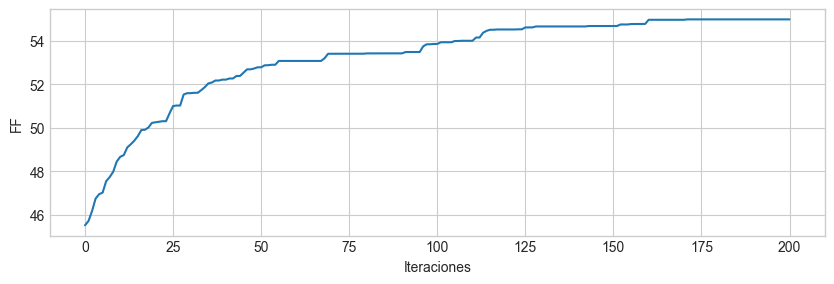

Total execution time: 401.9 secs 	 inicialization: 7.8 secs (0.02%) 	 iterations: 394.1 secs  (0.98%) 


In [70]:
#Paths
onto_path_one = 'data_test/mapping-freizeit/dmoz.Freizeit.owl'
onto_path_two = 'data_test/mapping-freizeit/Google.Freizeit.owl'

# onto_path_one = 'data_test/mapping-lebensmittel/Google.Lebensmittel.owl'
# onto_path_two = 'data_test/mapping-lebensmittel/web.Lebensmittel.owl'

max_iter = 200 #maxIterations (Generations)
pop_size = 100 #populationSize

#Select best
pct_elit = 0.1 #eliteFraction

#Crossover
pct_slct = 0.15 #selectFraction
pct_cros = 0.2 #crossPob

#Mutate
pct_muta = 0.2 #mutatePob

#Create ontology alignment
onto_align_res, lst_scr, exec_time = align_ontologies(onto_path_one, onto_path_two, 'GA', max_iter, 
                                        pop_size, pct_elit, pct_slct, pct_cros, pct_muta, dbg=False)

#Display line chart
plot_results(lst_scr)

#Execution time
init_time = round(exec_time[0],1)
iter_time = round(exec_time[1],1)
total_exec_time = round(sum(exec_time),1)
prc_init = round(init_time/total_exec_time,2)
prc_iter = round(iter_time/total_exec_time,2)

print("Total execution time: {} secs \t inicialization: {} secs ({}%) \t iterations: {} secs  ({}%) ".format(total_exec_time, init_time, prc_init, iter_time, prc_iter))

#Performance metrics
#precision, recall, f1_score = get_perform_metrics(onto_align_res, onto_align_ref)

In [33]:
lst_scr[len(lst_scr)-1][0][1]

55.333

In [34]:
precision, recall, f1_score = alignment_metrics(lst_ref_align, onto_align_res[0])

Precisión: 0.879
Recall: 0.879
F1-Score: 0.879


#### Experimentation (random parameters)

In [ ]:
def ga_test(onto_path_one, onto_path_two, max_tests=5, num_test=5):
    prm_max_iter = [50, 100, 200] #maxIterations (Generations)
    prm_pop_size = [50, 100, 150] #populationSize

    #Select best
    prm_pct_elit = [0.1, 0.2, 0.3] #eliteFraction

    #Crossover
    prm_pct_slct = [0.1, 0.15, 0.2] #selectFraction
    pct_cros = 0.2 #crossPob

    #Mutate
    prm_pct_muta = [0.1, 0.2, 0.3] #mutatePob
            
    lst_prm_sel = []
    lst_results = []
    
    n_tests = 0
    
    while n_tests < max_tests:
#         pos_max_iter = random.randint(0, len(prm_max_iter)-1)
#         pos_pop_size = random.randint(0, len(prm_pop_size)-1)
#         pos_pct_elit = random.randint(0, len(prm_pct_elit)-1)
#         pos_pct_slct = random.randint(0, len(prm_pct_slct)-1)
#         pos_pct_muta = random.randint(0, len(prm_pct_muta)-1)
        
#         max_iter = prm_max_iter[pos_max_iter]
#         pop_size = prm_pop_size[pos_pop_size]
#         pct_elit = prm_pct_elit[pos_pct_elit]
#         pct_slct = prm_pct_slct[pos_pct_slct]
#         pct_muta = prm_pct_muta[pos_pct_muta]

        max_iter = 200 #maxIterations (Generations)
        pop_size = 100 #populationSize
        pct_elit = 0.1 #eliteFraction
        #Crossover
        pct_slct = 0.15 #selectFraction
        pct_cros = 0.2 #crossPob
        #Mutate
        pct_muta = 0.2 #mutatePob
        
        prm_sel = []
        prm_sel.append(max_iter)
        prm_sel.append(pop_size)
        prm_sel.append(pct_elit)
        prm_sel.append(pct_slct)
        prm_sel.append(pct_muta)
        
        res_mtr = [.0, .0, .0]
        
        if prm_sel not in lst_prm_sel:
            #print(prm_sel)
            lst_prm_sel.append(prm_sel)
            
            for i in range(num_test):
                #Create ontology alignment
                onto_align_res, lst_scr, exec_time = align_ontologies(
                            onto_path_one, onto_path_two, 'GA', max_iter, 
                            pop_size, pct_elit, pct_slct, pct_cros, pct_muta, dbg=False)

                results = [
                            lst_scr[len(lst_scr)-1][0][1], #Max agregation score
                            round(exec_time[0],1), #init_time
                            round(exec_time[1],1), #iter_time
                            round(sum(exec_time),1) #total_exec_time
                          ]
                
                res_mtr[0], res_mtr[1], res_mtr[2] = alignment_metrics(lst_ref_align, onto_align_res[0])

                lst_results.append([n_tests+1]+prm_sel+results+res_mtr)
    
            n_tests += 1
        else:
            prm_sel.clear
            
    df_exp_res = pd.DataFrame(lst_results)
    df_exp_res.columns =['test', 'max_iter', 'pop_size', 'pct_elit', 'pct_slct', 'pct_muta',
                         'aggr_scr', 'init_time', 'iter_time', 'tot_time', 'precision', 'recall', 'f1_score'] 
    
    return df_exp_res

In [ ]:
onto_path_one = 'data_test/mapping-freizeit/dmoz.Freizeit.owl'
onto_path_two = 'data_test/mapping-freizeit/Google.Freizeit.owl'

df_exp = ga_test(onto_path_one, onto_path_two, 2)

In [ ]:
get_test_score(1)

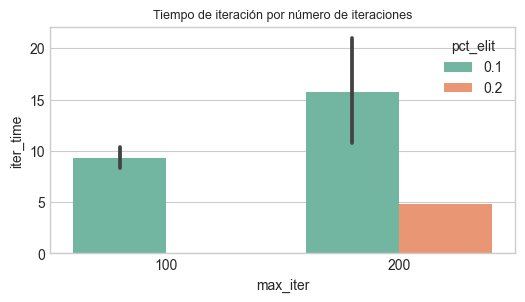

In [44]:
plt.title("Tiempo de iteración por número de iteraciones", fontsize=9)
ax = sns.barplot(x="max_iter", y="iter_time", hue="pct_elit", palette="Set2", data=df_exp)

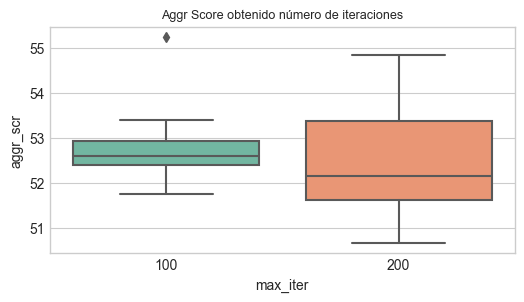

In [45]:
plt.title("Aggr Score obtenido número de iteraciones", fontsize=9)
ax = sns.boxplot(x="max_iter", y="aggr_scr", palette="Set2", data=df_exp)

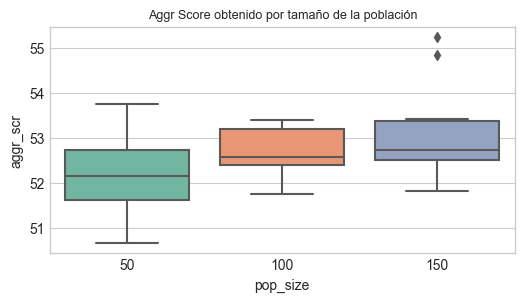

In [46]:
plt.title("Aggr Score obtenido por tamaño de la población", fontsize=9)
ax = sns.boxplot(x="pop_size", y="aggr_scr", palette="Set2", data=df_exp)

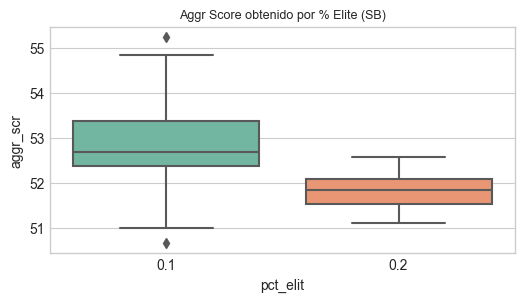

In [47]:
plt.title("Aggr Score obtenido por % Elite (SB)", fontsize=9)
ax = sns.boxplot(x="pct_elit", y="aggr_scr", palette="Set2", data=df_exp)

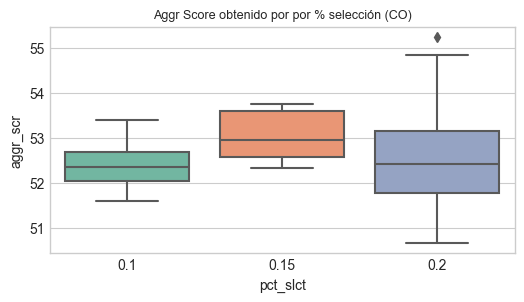

In [48]:
plt.title("Aggr Score obtenido por por % selección (CO)", fontsize=9)
ax = sns.boxplot(x="pct_slct", y="aggr_scr", palette="Set2", data=df_exp)

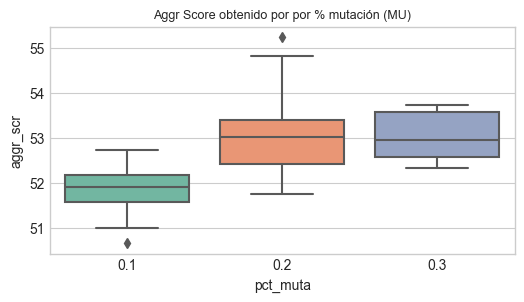

In [49]:
plt.title("Aggr Score obtenido por por % mutación (MU)", fontsize=9)
ax = sns.boxplot(x="pct_muta", y="aggr_scr", palette="Set2", data=df_exp)

<AxesSubplot:xlabel='iter_time', ylabel='aggr_scr'>

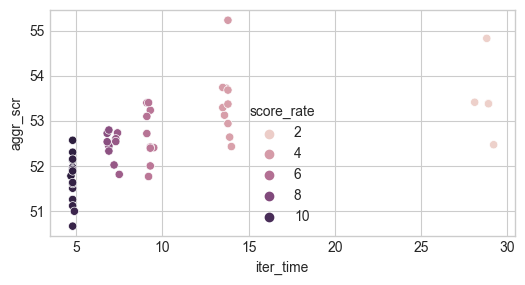

In [50]:
score_rate = df_exp.eval("aggr_scr / iter_time").rename("score_rate")
sns.scatterplot(data=df_exp, x="iter_time", y="aggr_scr", hue=score_rate)

### Metaheurística de solución única

#### BUSQUEDA LOCAL ITERATIVA
Función general

In [51]:
def iterative_local_seach(onto_sm, onto_lg, num_iter):
    start = time.time()
    
    #Create initial solution
    found_solution = create_local_solution(onto_sm, onto_sm)
    
    #Greedy
    for it in range(num_iter):
        candidate_solution = create_local_solution(onto_sm, onto_lg)                
        if get_alignment_score(candidate_solution) > get_alignment_score(found_solution):
            found_solution = candidate_solution
    
    end = time.time()
    nseg = end - start
    
    return found_solution, get_alignment_score(found_solution), nseg

def iterative_local_seach2(onto_sm, onto_lg, num_iter, max_attempts = 10):
    start = time.time()     
    
    #Create initial solution
    found_solution = create_local_solution(onto_sm, onto_sm)
    
    for it in range(num_iter):
        candidate_solution = create_local_solution(onto_sm, onto_lg)
        attempts = 0
        
        while get_alignment_score(found_solution) < get_alignment_score(candidate_solution) and attempts <= max_attempts:
            found_solution = create_local_solution(onto_sm, onto_sm)                   
            attempts += 1
                
    end = time.time()
    nseg = end - start
    
    return found_solution, get_alignment_score(found_solution), nseg

def create_local_solution(onto_sm, onto_lg, ns_size=20):
    solutions = generate_rnd_onto_alignment(ns_size, onto_sm, onto_lg, False)
    solution, agr_scr = select_best(solutions, 1)
    return solution[0]

#### Ejecutar

In [52]:
lst_itr = [5, 10, 25, 50, 100, 150] #Number of iterations 
lst_scr = [] #Score list
lst_xtm = [] #Execution time list

onto_path_two = 'pizza_1.owl'
onto_path_two = 'pizza_2.owl'

for nitr in lst_itr:
    onto_align_ils, ils_scr, exec_time = align_ontologies(onto_path_one, onto_path_two, 'ILS', max_iter=nitr)
    lst_scr.append(ils_scr)
    lst_xtm.append(round(exec_time, 1))

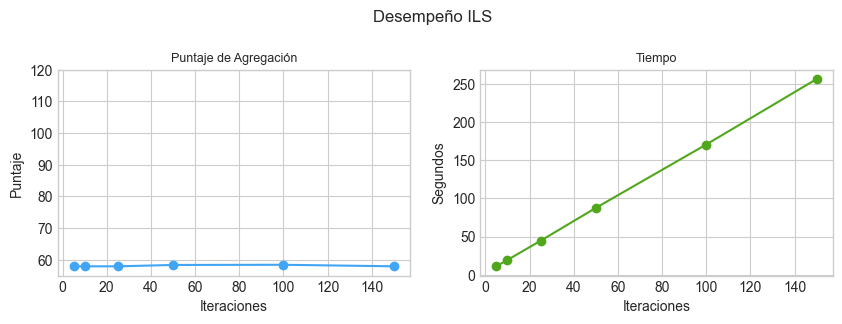

Agregration scores: [57.893, 57.932, 57.92, 58.355, 58.409, 57.93]
Execution time: [11.2, 19.4, 44.6, 87.6, 170.7, 256.5] seg


In [58]:
plot_perfomance(lst_itr, lst_scr, lst_xtm)

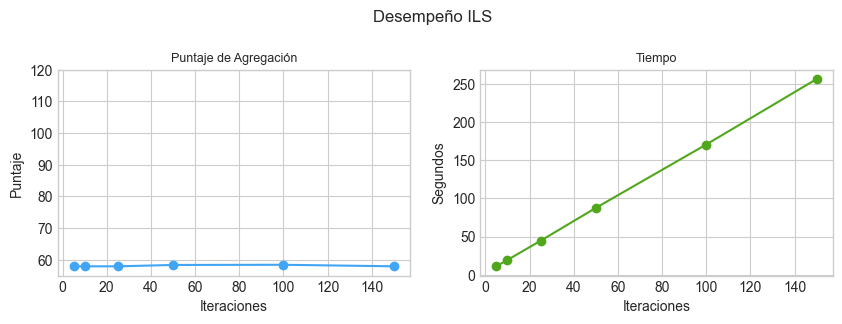

Agregration scores: [57.893, 57.932, 57.92, 58.355, 58.409, 57.93]
Execution time: [11.2, 19.4, 44.6, 87.6, 170.7, 256.5] seg


In [59]:
plot_perfomance(lst_itr, lst_scr, lst_xtm)